In [1]:
from data_utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from feature_utils import *
from functions import *
import json

,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor,Label
count,14008.000000,14008.000000,14008.000000,14008.000000,14008.000000,14008.000000
mean,1.119788,16.499286,7.578712,7.851270,9.645750,0.500000
std,0.750514,1.194180,0.699656,0.669035,6.462807,0.500018
min,0.013548,9.525641,4.129490,4.501692,0.267417,0.000000
25%,0.554715,15.769624,7.128637,7.416543,5.035243,0.000000
50%,0.915679,16.412236,7.610338,7.900751,8.179345,0.500000
75%,1.550101,17.318433,8.093824,8.346411,12.861070,1.000000
max,7.832202,21.386887,9.985896,10.135856,78.937504,1.000000


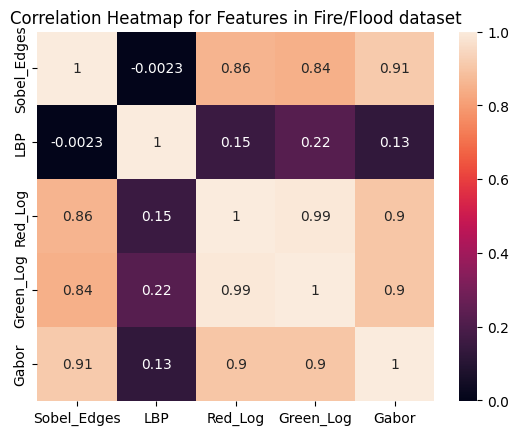

In [2]:
# Load in the dataset from the csv file
logistic_features = pd.read_csv("socal_fires_midwest_floods.csv")

#Correlation Heatmap for all features
features_only = logistic_features.drop(columns=['Label'])

heatmap = sns.heatmap(features_only.corr(), annot=True)
heatmap.set_title('Correlation Heatmap for Features in Fire/Flood dataset')

#We see from this data that several of our features have high collinearity, and thus will not be useful in our model

logistic_features.describe()

## Model Training

## CNN

In [4]:
# necessary imports and definitions for this section
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
from PIL import Image
from sklearn.metrics import f1_score

#Used this tutorial for help: https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

#Preprocess the images (resize) so they are all the same size (64 x 64)
def resize(images, size=(64, 64)):
    resized = []
    for image in images:
        image = Image.fromarray(image)
        image = image.resize(size)
        resized.append(np.array(image))
    return np.array(resized)

#Converting to Tensor (for use with PyTorch), and normalizing images
def toTensor(imageset):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    tensor = [transform(Image.fromarray(image)) for image in imageset]
    return torch.stack(tensor)

# Creating a CNN class
class ConvNeuralNet(nn.Module):

    def __init__(self, num_classes=2): #takes in number of classes, default at 4 for hurricane dataset
        super(ConvNeuralNet, self).__init__()
        #2 layers with a max pooling layer. 3 kernels for RGB data
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12) 
        self.conv_layer2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu1 = nn.ReLU() 
        
        #another 2 layers with a max pooling layer
        self.conv_layer3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1) # 2 more layers with another max pooling layer
        self.bn3 = nn.BatchNorm2d(24)
        self.conv_layer4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu2 = nn.ReLU() 

        #another 2 layers with a max pooling layer
        self.conv_layer5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1) # 2 more layers with another max pooling layer
        self.bn5 = nn.BatchNorm2d(24)
        self.conv_layer6 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(48)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu3 = nn.ReLU() 

        #dropout layer to help with overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # 64 x 64 tensor images, pooled 3x with kernel size = 2, so they're now 8x8
        # 8 x 8 x 48 (how many we generated)
        self.fc1 = nn.Linear( 8* 8 * 48, num_classes) #linear layer that maps to the classes
    
    # Moving images through CNN    
    def forward(self, x): 
        out = self.conv_layer1(x) #first conv layer
        out = self.bn1(out) #batch normalization
        out = self.conv_layer2(out) #second conv layer
        out = self.bn2(out) #batch normalization
        out = self.max_pool1(out) #max pooling layer (dimensionality reduction)
        out = self.relu1(out) #relu activation
        
        out = self.conv_layer3(out) #third conv layer
        out = self.bn3(out) #batch normalization
        out = self.conv_layer4(out) #fourth conv layer
        out = self.bn4(out) #batch normalization
        out = self.max_pool2(out) #max pooling layer (dimensionality reduction)
        out = self.relu2(out) #relu activation

        out = self.conv_layer5(out) #fifth conv layer
        out = self.bn5(out) #batch normalization
        out = self.conv_layer6(out) #sixth conv layer
        out = self.bn6(out) #batch normalization
        out = self.max_pool3(out) #max pooling layer (dimensionality reduction)
        out = self.relu3(out) #relu activation
        
        out = self.drop(out) #dropout layer
        
        out = out.reshape(out.size(0), -1) # flattens to 1D before feeding to linear layers
        
        out = self.fc1(out) # fully connected layer
        return out




### Preprocessing the images and labels

In [5]:
# loading in the raw images 

disaster_list = ["socal-fire", "midwest-flooding"]

data = {}
split = "train"

with open('config.json') as config_file:
    config = json.load(config_file)
    # data_dir = "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/satellite-image-data"
    data_dir = "../satellite-image-data"

for disaster in disaster_list:
    print(f"Loading {split} images and labels for {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

# choose socal-fires and midwest floods from our labels list 
socal_fires_labels = data[disaster_list[0]]["labels"]
socal_fires_images = data[disaster_list[0]]["images"]
midwest_floods_labels = data[disaster_list[1]]["labels"]
midwest_floods_images = data[disaster_list[1]]["images"]


Loading train images and labels for socal-fire dataset...
Loading train images and labels for midwest-flooding dataset...


In [6]:
#Setting labels for floods vs fires

socal_fires_labels_cnn = np.ones_like(socal_fires_labels)
midwest_floods_labels_cnn = np.zeros_like(midwest_floods_labels)


#Resizing the images
socal_fires_resized = resize(socal_fires_images) #8380
midwest_floods_resized = resize(midwest_floods_images) #7004

#Joining the datasets
ff_images = np.concatenate([socal_fires_resized, midwest_floods_resized])
ff_labels = np.concatenate([socal_fires_labels_cnn, midwest_floods_labels_cnn])

#converting all images to tensors
ff_images_tensor = toTensor(ff_images)

#cnverting labels to tensor
ff_labels_tensor = torch.tensor(ff_labels, dtype=torch.long)

In [7]:
fires = 8380 / len(ff_images)
floods = 7004/ len(ff_images)

display(fires)
display(floods)

0.5447217888715549

0.45527821112844513

### Creating Loader objects for PyTorch

In [8]:
from sklearn.model_selection import train_test_split

#Split into validation and training sets
X_train_CNN, X_valid_CNN, y_train_CNN, y_valid_CNN = train_test_split(ff_images_tensor, ff_labels_tensor, test_size=0.2, random_state=42)

#Create tensor datasets to load into the loader object
train_dataset = TensorDataset(X_train_CNN, y_train_CNN)
valid_dataset = TensorDataset(X_valid_CNN, y_valid_CNN)

#Create loader objects (preserves memory by only loading the images batch by batch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)


### CNN Class

### Hyperparameters

In [9]:
num_classes = 2 #number of classes in our dataset
learning_rate = 0.001 #initializing initial learning rate

# set device to run 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#setting up model using our custom class
model_test = ConvNeuralNet(num_classes).to(device)

# using cross entropy for the loss function
class_weights = torch.tensor([fires, floods], device=device)
loss_func = nn.CrossEntropyLoss(weight=class_weights)

# set optimizer for CNN (stochastic gradient descent)
optimizer = torch.optim.SGD(model_test.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

#takes ~20 mins to run!
num_epochs = 15 #number of times to run the CNN

### Training the CNN

In [10]:
#Counters for visualization of training loss and accuracy
train_loss = []
train_accuracy = []
train_f1 = []

for epoch in range(num_epochs):
    #training mode
    model_test.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    true_labels = []
    pred_labels = []

    # user loader object to load the data
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward through the CNN
        outputs = model_test(images) 
        loss = loss_func(outputs, labels) #calculate loss
        
        # Backpropagation, optimize parameters
        optimizer.zero_grad() #use SGD to optimize weights
        loss.backward() #check new gradient with loss function
        optimizer.step() #update weights

        running_loss += loss.item() #add all loss over this loop to running_loss

        _, predicted_train = torch.max(outputs.data, 1) # get current prediction for this epoch
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item() #compare prediction with label

        true_labels.extend(labels.cpu().numpy()) #adding true labels to a flat list
        pred_labels.extend(predicted_train.cpu().numpy()) #adding pred labels to a flat list

    
    # Calculate average loss and accuracy over the epoch
    avg_loss = running_loss / len(train_loader) #gives the average loss over the epoch
    train_loss.append(avg_loss)
    t_accuracy = 100 * correct_train / total_train
    train_accuracy.append(t_accuracy)
    train_f1.append(f1_score(true_labels, pred_labels, average='weighted'))
    
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_accuracy[-1]:.2f}%, F1 Score: {train_f1[-1]:.4f}')



Epoch [1/15], Loss: 0.2141, Accuracy: 91.49%, F1 Score: 0.9150
Epoch [2/15], Loss: 0.1170, Accuracy: 95.86%, F1 Score: 0.9586
Epoch [3/15], Loss: 0.0839, Accuracy: 96.97%, F1 Score: 0.9697
Epoch [4/15], Loss: 0.0784, Accuracy: 97.05%, F1 Score: 0.9705
Epoch [5/15], Loss: 0.0656, Accuracy: 97.62%, F1 Score: 0.9762
Epoch [6/15], Loss: 0.0597, Accuracy: 97.98%, F1 Score: 0.9799
Epoch [7/15], Loss: 0.0544, Accuracy: 98.08%, F1 Score: 0.9808
Epoch [8/15], Loss: 0.0451, Accuracy: 98.35%, F1 Score: 0.9835
Epoch [9/15], Loss: 0.0539, Accuracy: 98.17%, F1 Score: 0.9817
Epoch [10/15], Loss: 0.0408, Accuracy: 98.48%, F1 Score: 0.9848
Epoch [11/15], Loss: 0.0342, Accuracy: 98.76%, F1 Score: 0.9876
Epoch [12/15], Loss: 0.0342, Accuracy: 98.76%, F1 Score: 0.9877
Epoch [13/15], Loss: 0.0326, Accuracy: 98.73%, F1 Score: 0.9873
Epoch [14/15], Loss: 0.0291, Accuracy: 98.90%, F1 Score: 0.9890
Epoch [15/15], Loss: 0.0340, Accuracy: 98.81%, F1 Score: 0.9881


### Testing the CNN

In [19]:
#Running validation set through the optimized CNN to calculate accuracy

model_test.eval() #model in evaluation mode


#collecting metrics from validation evaluation run as well
valid_running_loss = 0.0
correct_valid = 0
total_valid = 0
true_labels_valid = []
pred_labels_valid = []

#do not need gradient optimization for validation set
with torch.no_grad(): 
    for images, labels in valid_loader: 
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_test(images)

        #loss
        loss = loss_func(outputs, labels)
        valid_running_loss += loss.item()

        #accuracy
        _, predicted_valid = torch.max(outputs.data, 1)
        total_valid += labels.size(0)
        correct_valid += (predicted_valid == labels).sum().item()

        true_labels_valid.extend(labels.cpu().numpy())
        pred_labels_valid.extend(predicted_valid.cpu().numpy())

avg_valid_loss = valid_running_loss / len(valid_loader)
valid_accuracy =  100 * correct_valid / total_valid
valid_f1 = f1_score(true_labels_valid, pred_labels_valid, average='weighted')

    
print(f'Validation Loss: {avg_valid_loss:.4f}')
print(f'Validation Accuracy: {valid_accuracy:.2f}%')
print(f'Validation F1 Score: {valid_f1:.4f}')

Validation Loss: 0.0603
Validation Accuracy: 97.86%
Validation F1 Score: 0.9786


### CNN Loss and Accuracy Visualization

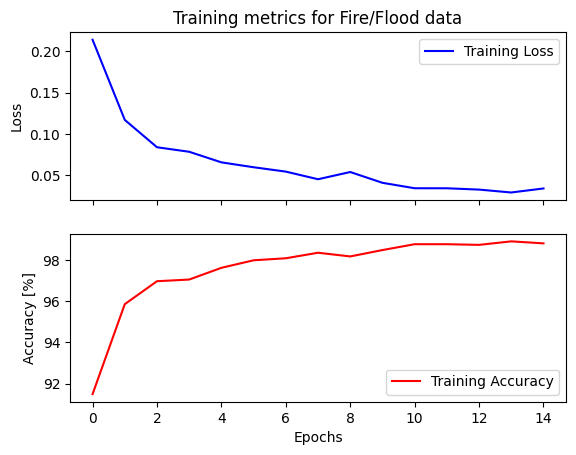

In [17]:
#Visualization of training loss and accuracy

xplot = np.arange(num_epochs)

fig1, ax1 = plt.subplots(2, 1, sharex = True)
ax1[0].set_title("Training metrics for Fire/Flood data")
ax1[0].plot(xplot, train_loss, 'blue', label="Training Loss")
ax1[0].set_ylabel('Loss')
ax1[0].legend()
ax1[1].plot(xplot, train_accuracy, 'red', label='Training Accuracy')
ax1[1].set_ylabel('Accuracy [%]')
ax1[1].legend()
plt.xlabel('Epochs')
plt.show()

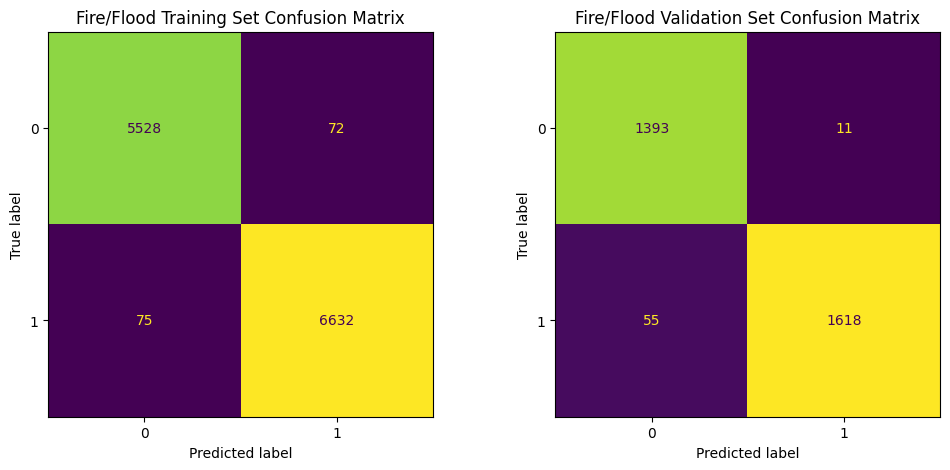

In [22]:
train_cm = confusion_matrix(true_labels, pred_labels)
test_cm = confusion_matrix(true_labels_valid, pred_labels_valid)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(train_cm, display_labels=[0, 1]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Fire/Flood Training Set Confusion Matrix")
ConfusionMatrixDisplay(test_cm, display_labels=[0, 1]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Fire/Flood Validation Set Confusion Matrix")

plt.show()

## Performance Assessment

Use the model to generate predictions for the `test_images_flooding-fire.npz` images. This should be in a csv file `test_images_flooding-fire_predictions.csv` consisting of a single column with no header, with a 0 to indicate a `midwest-flooding` prediction and a 1 to indicate a `socal-fire` prediction. The prediction in row *i* should correspond to the *ith* image.

In [49]:
test_im_flood_fire_path = os.path.join(data_dir, "test_images_flooding-fire.npz")
test_im_flood_fire = load_images(test_im_flood_fire_path)

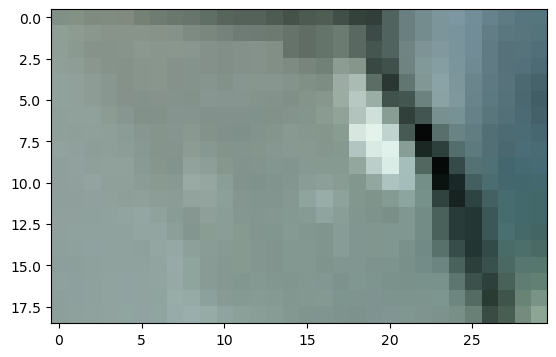

In [36]:
plt.imshow(test_im_flood_fire[0]);

## Logistic

In [37]:
test_sobel_edges = img_to_sobel(test_im_flood_fire)
test_lbp = (img_to_LBP(test_im_flood_fire))  
test_red, test_green, test_blue = image_to_RGB(test_im_flood_fire)
test_red_log = np.log(np.array(test_red))
test_green_log = np.log(np.array(test_green))
test_blue_log = np.log(np.array(test_blue))  # not used, keeping for consistency
test_gabor = img_to_gabor(test_im_flood_fire)

In [38]:
# Combine all features into df
test_features = pd.DataFrame({
    'Sobel_Edges': test_sobel_edges,
    "LBP": test_lbp,
    'Red_Log': test_red_log,
    'Green_Log': test_green_log,
    'Gabor': test_gabor
})

In [39]:
test_predictions = model.predict(test_features)
output_path = "logistic_test_images_flooding-fire_predictions.csv"
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

## Gradient Descent Logistic

In [40]:
def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)
    return [1 if i > 0.5 else 0 for i in y_pred]

pca_test = pca_obj.transform(test_features)

test_predictions = predict(pca_test, weights, bias)

output_path = "gradient_logistic_test_images_flooding-fire_predictions.csv"
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

print(f"Predictions saved to {output_path}")

Predictions saved to gradient_logistic_test_images_flooding-fire_predictions.csv


/tmp/ipykernel_1539028/896558915.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


## CNN

In [50]:
# Define a loader for the test dataset
test_images = resize(test_im_flood_fire)
test_features = toTensor(test_images)

test_dataset = TensorDataset(test_features)

test_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

model_test.eval() #model in test mode

test_predictions = []

#do not need gradient optimization 
with torch.no_grad(): 
    for images in test_loader: 
        images = images[0].to(device)
        outputs = model_test(images)

        _, predicted = torch.max(outputs.data, 1)

        test_predictions.extend(predicted.cpu().numpy())


output_path = "cnn_test_images_flooding-fire_predictions_v5.csv"
predictions_df = pd.DataFrame(test_predictions, columns=["pred"])
predictions_df.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")

Predictions saved to cnn_test_images_flooding-fire_predictions_v5.csv
